# Exploration in Linear Bandits

The objective of this part is to implement and compare the following strategies for linear bandits:

[Optimism in the Face of Uncertainty (OFUL)](https://papers.nips.cc/paper/4417-improved-algorithms-for-linear-stochastic-bandits.pdf)

[Thompson Sampling](https://projecteuclid.org/euclid.ejs/1513306870)

## Linear bandit
We consider the standard linear bandit setting. At each time $t$, the agent selects an arm $a_t \in A$ and observes a reward
$$
r_{a}^t = \langle \theta^\star, \phi_a^t \rangle + \eta_a^t := \mu_a^t + \eta_a^t
$$
where $\theta^{\star} \in \mathbb{R}^{d}$ is a parameter vector, $\phi_{a}^t \in \mathbb{R}^{d} $ are the features of arm $a$ at time $t$, and $\eta_{a}^{t}$ is a zero-mean  $\sigma^2$-subgaussian noise. 

When the features correspond to the canonical basis, this formulation reduces to multi-armed bandit (MAB) with $d$ arms. In the more general case, the features may depend on a context $x_t$, so that $\phi_a^t = \phi(x_t, a)$ denotes the feature vector of a context-action pair $(x_t, a)$ and the resulting setting is the so-called linear contextual bandit.

We rely on the following standard assumption on the features and the unknown parameter $\theta^\star$.

**Assumption.** There exist $B,D \geq 0$, such that $\|\theta^\star\|_2 \leq B$, $\|\phi_a^t\| \leq D$, and $\langle \theta^\star, \phi_a^t \rangle \in [0,1]$, for all $t$ and $a$.

Given a finite horizon $n$, the performance of the agent is measured by its (pseudo)-\emph{regret}:
$$
        %R(n) = n \mu^{\star} - \sum_{t=1}^n \mu_{a_t} = \sum_{i=1}^K T_i(n) \Delta_i, 
        R(n) = \sum_{t=1}^n \langle \theta^\star, \phi_{a^\star}^t \rangle - \langle \theta^\star, \phi_{a_t}^t \rangle ,
$$
where $a^{\star}_{t} \in \arg\max_{a} \langle \theta^\star, \phi_{a}^t \rangle$ is the optimal action at time $t$.

**We consider the simple linear bandit setting:** $\phi_a^t = \phi_a, \; \forall t$




In [52]:
!rm -rf mvarl_hands_on/
!git clone https://github.com/rlgammazero/mvarl_hands_on.git
!cd mvarl_hands_on/ && git fetch
!ls mvarl_hands_on/utils

Cloning into 'mvarl_hands_on'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 39 (delta 14), reused 37 (delta 12), pack-reused 0
Unpacking objects: 100% (39/39), done.
cliffwalk.py      discretization.py frozen_lake.py    test_env.py
coldstart.py      finite_env.py     gridworld.py


In [53]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import os
import numpy as np
from pprint import pprint
from coldstart import ColdStartFromDataset
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from tqdm import tqdm

#### Jester Jokes Dataset (Dense subset of 40 jokes)

Deep Bayesian Bandits Showdown: An Empirical Comparison of Bayesian Deep Networks for Thompson Sampling

Download the data at: https://storage.googleapis.com/bandits_datasets/jester_data_40jokes_19181users.npy

We performed a matrix factorization of the ratings (after filtering over users and jokes). This provides features for the arms and users, the reward (ie rating) is the dot product between the arm and user features (we make it stochastic by adding Gaussian noise). We consider a cold start problem where the user is randomly selected at the beginning of the repetition and the agent has to learn the best arm to recommend. When an arm is selected by the algorithm, its reward is computed as the dot product between the arm and user features.

In [54]:
!wget https://storage.googleapis.com/bandits_datasets/jester_data_40jokes_19181users.npy

--2020-01-06 10:01:57--  https://storage.googleapis.com/bandits_datasets/jester_data_40jokes_19181users.npy
Resolving storage.googleapis.com... 216.58.215.48, 2a00:1450:4007:808::2010
Connecting to storage.googleapis.com|216.58.215.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6138000 (5.9M) [application/octet-stream]
Saving to: 'jester_data_40jokes_19181users.npy.4'

jester_data_40jokes 100%[===================>]   5.85M  2.59MB/s    in 2.3s    

2020-01-06 10:02:00 (2.59 MB/s) - 'jester_data_40jokes_19181users.npy.4' saved [6138000/6138000]



In [77]:
M = np.load('jester_data_40jokes_19181users.npy')
M = M / 10
K = 35
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)
print('U: {}'.format(U.shape))
print('Vt: {}'.format(Vt.shape))
print('#features: {}'.format(Vt.shape[0]))
print('#arms: {}'.format(Vt.shape[1]))
np.savetxt('U_jester.csv', U, delimiter=',') 
np.savetxt('Vt_jester.csv', Vt, delimiter=',') 

U: (19181, 35)
Vt: (35, 40)
#features: 35
#arms: 40


Create the coldstart model

In [78]:
seed = 1235
user_subset = np.linspace(0, 400, 10).astype(int).tolist()
arm_csvfile = os.path.abspath('Vt_jester.csv')
user_csvfile = os.path.abspath('U_jester.csv')
noise_std = 0.1

config_cs = {
    'arm_csvfile': arm_csvfile,
    'user_csvfile': user_csvfile,
    'random_state': seed,
    'user_subset': user_subset,
    'noise_std': noise_std
}

print("Current config is:")
pprint(config_cs)


Current config is:
{'arm_csvfile': '/Users/macbookthibaultlahire/Documents/THIBAULT/MVA/Reinforcement '
                'Learning/HW2/Vt_jester.csv',
 'noise_std': 0.1,
 'random_state': 1235,
 'user_csvfile': '/Users/macbookthibaultlahire/Documents/THIBAULT/MVA/Reinforcement '
                 'Learning/HW2/U_jester.csv',
 'user_subset': [0, 44, 88, 133, 177, 222, 266, 311, 355, 400]}


In [79]:
noise = 0.2
random_state = 312
model = ColdStartFromDataset(**config_cs)
print("\nThe new user arriving to the system is user #", model.theta_idx)
print("\nTheta*: ", model.theta)
print("\nFeatures: ", model.features.shape)
means = np.dot(model.features, model.theta)
print("\nMeans: ", means)
theta_bound = np.linalg.norm(model.theta, 2)
print("\nTheta bound: ", theta_bound)


The new user arriving to the system is user # 311

Theta*:  [-2.05731720e-01 -9.45157719e-01  9.50761332e-01 -1.48720528e-02
  1.76227226e-01 -6.95983198e-01  6.39863132e-01 -1.64450643e-03
 -1.08638553e-01  9.09231305e-01  8.63061011e-01 -2.17325440e-02
 -3.87783826e-01 -4.41767546e-01  5.06214560e-02 -5.61302896e-01
  1.26926842e-01 -1.45078756e-02 -1.30910533e-01  8.39172840e-01
 -4.60797788e-02 -4.39751439e-01 -9.43671932e-01 -1.72604133e+00
 -4.55566477e-01  1.68812233e-02  4.42198404e-02  8.51523188e-01
  8.22963549e-01 -3.19290590e-01 -1.16922306e+00  1.82183628e+00
  1.05241405e+00  1.47024897e-01  9.67396289e-01]

Features:  (40, 35)

Means:  [0.47568973 0.22610898 0.90761638 0.82336161 0.76435307 0.26546461
 0.22117241 0.3152374  0.13810922 1.         0.69295802 0.97246014
 0.25034471 0.18352382 0.85997635 0.2307719  0.84371419 0.9832823
 0.17995533 0.89900143 0.83450034 0.26055666 0.76369083 0.6721658
 0.29845689 0.30426726 0.16228881 0.26092709 0.6385817  0.
 0.58778865 0.

**Question 1**: implement OFUL

### LinUCB / OFUL
See the slides!

Note that it is not necessary to invert the matrix $A_t$ at each round. Since $A_t$ is obtained from a rank-1 update of $A_{t-1}$, it is possible to use Sherman–Morrison formula to build directly $A_t^{-1}$.

Suppose $𝐴$ be a nonsingular $n\times n$ matrix and $\mathbf{u}, \mathbf{v}$ be vectors. Then
$$
(A+\mathbf{u}\mathbf{v}^T)^{-1} = A^{-1} - \frac{A^{-1}\mathbf{u}\mathbf{v}^TA^{-1}}{1+\mathbf{v}^TA^{-1}\mathbf{u}}.
$$

In [80]:
class OFUL:
    def __init__(self, arm_features, reg_factor, delta, bound_theta, noise_std):
        self.arm_features = arm_features
        self.reg_factor = reg_factor
        self.delta = delta
        self.iteration = 0
        self.bound_theta = bound_theta
        self.bound_features = np.max(np.sqrt(np.sum(np.abs(arm_features) ** 2, axis=1)))
        self.noise_std = noise_std

        self.beta = 0
        self.b = np.zeros(self.arm_features.shape[1])
        self.A_inv = np.eye(self.arm_features.shape[1])/reg_factor
        self.theta_hat = np.zeros(self.arm_features.shape[1])
        
        self.n_act = self.arm_features.shape[0]
        self.n_feat = self.arm_features.shape[1]
        

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        actions = alg.arm_features.dot(self.theta_hat) + self.beta*np.sqrt(np.diag(self.arm_features.dot(self.A_inv.dot(self.arm_features.T))))
        return np.argmax(actions)
        
    def update(self, a_t, r_t):
        """Update the estimates of the model
        

        Parameters
        ----------
        a_t: int
            The action played at the current episode
        r_t: float
            The reward associated to action a_t

        Returns
        -------
        none
        """
        self.beta = self.noise_std * np.sqrt(self.n_feat*np.log((1+(self.bound_features*self.iteration)/self.reg_factor)/self.delta)) + np.sum(self.theta_hat**2)*np.sqrt(self.reg_factor)
        self.b += r_t * self.arm_features[a_t]
        self.A_inv = self.A_inv - self.A_inv.dot(np.array([self.arm_features[a_t]]).T).dot(np.array([self.arm_features[a_t]])).dot(self.A_inv)/(1 + np.array([self.arm_features[a_t]]).dot(self.A_inv).dot(np.array([self.arm_features[a_t]]).T))
        self.theta_hat = self.A_inv.dot(self.b)
    

**Question 2:** implement LinearTS

Let $A_t$ be the design matrix, $\theta_t$ the estimate of $\theta^\star$ and $\beta_t$ the confidence interval built by LinUCB. Then, at every time step t,  LinearTS simply generates
a sample $\tilde{\theta}_t$ from the distribution $\mathcal{N}(\widehat{\theta}_t, \omega_t \beta_t^2 A_t^{-1})$.

LinearTS

For $t=1, \ldots, T$
> $\tilde{\theta}_t \sim \mathcal{N}(\widehat{\theta}_t, \omega_t \beta_t^2 A_t^{-1})$
>
> $a_t \in \arg\max_{a \in \mathcal{A}_t}  \langle \tilde{\theta}_t, \phi_{a} \rangle$
>
> observe reward $r_t$

TS is requires to draw $\tilde{\theta}_t$ from a distribution over-sampling by a factor $\sqrt{d}$ the ellipsoid constructed by OFUL (i.e., $\omega_t = d$). This is required to prove that LinearTS is optimistic with a fix probability. This is necessary to prove the frequentist regret of TS. The regret of TS is worse than the one of OFUL by a factor $\sqrt{d}$ (i.e., $\widetilde{O}(d^{3/2}\sqrt{T})$)

In [81]:
class LinearTS(OFUL):
    def __init__(self, arm_features, reg_factor, delta, bound_theta, noise_std):
        super(LinearTS, self).__init__(arm_features, reg_factor, delta, bound_theta, noise_std)
    
    def sample_action(self):
        """Return the action to play based on current estimates
        """
        theta_tild = np.random.multivariate_normal(self.theta_hat, np.sqrt(self.n_feat)*self.beta**2*self.A_inv)
        return np.argmax(self.arm_features.dot(theta_tild))
        

<div class="alert alert-danger">

An important remark has to be done. In the cell above, there is an oversampling by a factor $\sqrt d$, which corresponds to the "term" np.sqrt(self.n_feat) in the function sample_action defined above. Note that, if we remove this "term", and only consider 
```python
theta_tild = np.random.multivariate_normal(self.theta_hat, self.beta**2*self.A_inv)
```
then we obtain a result similar to the one posted on piazza !

**Question 3**: run the algorithms (`OFUL` and `LinearTS`) and average the performance over multiple users (ie simulations)

The regret $R(T) = \sum_t \phi_t^\top (\theta^\star - \theta_t)$

The performance is the expected regret over multiple users. You can also test `LinearTS` without the additional $\sqrt{d}$.

You can use `RandomLinearArms` to test your code before using Jester

In [82]:
# from mvarl_hands_on.utils.coldstart import RandomLinearArms

nb_simulations = 4
T = int(5e4)

algorithms = {
            'OFUL': lambda arm_features, bound_theta: 
              OFUL(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std']),
             'LinearTS': lambda arm_features, bound_theta:
              LinearTS(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std'])
             }

regrets = {}

for alg_name in algorithms.keys():
    if alg_name not in regrets.keys():
        regrets[alg_name] = np.zeros((nb_simulations, T))
    
    for k in range(nb_simulations):
        if k % 1 == 0:
            print("{} simulation {}/{}".format(alg_name, k+1, nb_simulations))
        model = ColdStartFromDataset(**config_cs)
#         model = RandomLinearArms()
        alg = algorithms[alg_name](arm_features=model.features, bound_theta=np.linalg.norm(model.theta, 2))
        for t in range(T):
            alg.iteration = t
            a_t = alg.sample_action()
            r_t = model.reward(a_t)

            alg.update(a_t, r_t)
            
            regrets[alg_name][k, t] = model.best_arm_reward() - r_t


OFUL simulation 1/4
OFUL simulation 2/4
OFUL simulation 3/4
OFUL simulation 4/4
LinearTS simulation 1/4
LinearTS simulation 2/4
LinearTS simulation 3/4
LinearTS simulation 4/4


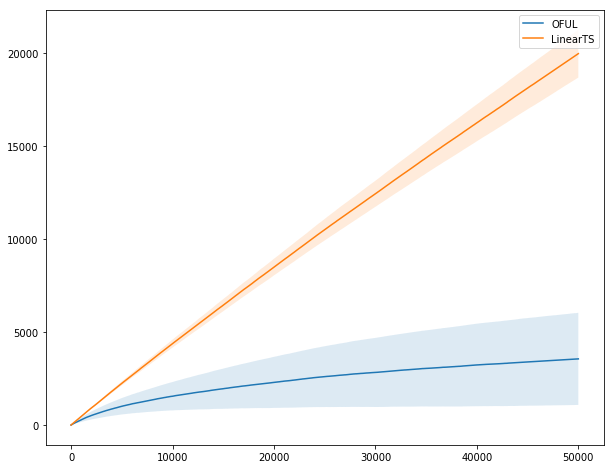

In [83]:
plt.figure(figsize=(10,8))
for alg_name in regrets.keys():
    data = np.cumsum(regrets[alg_name], axis=1)
    n_rep, T = data.shape
    mean_regret = np.mean(data, axis=0)
    std_regret = np.std(data, axis=0) / math.sqrt(n_rep)
    t = np.arange(T)
    plt.plot(t, mean_regret, label=alg_name)
    plt.fill_between(t, mean_regret - 2 * std_regret, mean_regret + 2 * std_regret, alpha=0.15)
plt.legend()